In [1]:
import cv2
import numpy as np
from sklearn.utils import shuffle
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
DOWNLOAD_PATH = "./data/temp/"
DATA_PATH = "./data"
ZIP_NAME = "fer2013.zip"
TEMP_ZIP_FILE_PATH = os.path.join(DOWNLOAD_PATH, ZIP_NAME)
TRAIN_PATH = os.path.join(DATA_PATH, "train")
TEST_PATH = os.path.join(DATA_PATH, "test")

In [3]:
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

!curl -L -o {TEMP_ZIP_FILE_PATH} https://www.kaggle.com/api/v1/datasets/download/msambare/fer2013

with zipfile.ZipFile(TEMP_ZIP_FILE_PATH, "r") as zip:
    zip.extractall(DATA_PATH)

os.remove(TEMP_ZIP_FILE_PATH)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 60.3M  100 60.3M    0     0  7964k      0  0:00:07  0:00:07 --:--:-- 10.3M


In [3]:
def load_dataset(PATH):
    CLASS_NAMES = sorted(os.listdir(PATH))
    LABEL_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}
    
    images = []
    labels = []
    
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(PATH, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(LABEL_MAP[class_name])
    images = np.array(images)
    labels = np.array(labels)
    images, labels = shuffle(images, labels, random_state=42)
    return images, labels, LABEL_MAP

In [4]:
X_train, y_train, LABEL_MAP = load_dataset(TRAIN_PATH)
X_test, y_test, _ = load_dataset(TEST_PATH)

X_train.shape, y_train.shape, LABEL_MAP

((28709, 48, 48, 3),
 (28709,),
 {'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6})

In [5]:
X_train[0].shape

(48, 48, 3)

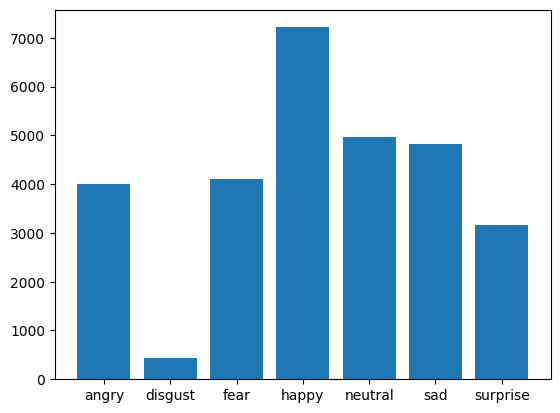

In [6]:
plt.bar(LABEL_MAP.keys(), np.bincount(y_train))
plt.show()

In [7]:
import os
import tensorflow as tf

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import cv2
import numpy as np

IMG_SIZE = 48
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Normaliza
X_train_resized = X_train.astype("float32") / 255.0
X_test_resized = X_test.astype("float32") / 255.0

# One-hot
y_train_cat = to_categorical(y_train, num_classes=len(LABEL_MAP))
y_test_cat = to_categorical(y_test, num_classes=len(LABEL_MAP))

print(X_test_resized.shape)

# Modelo base
base_model = DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=(48,48,3),
    pooling=None,
    classes=7,
    classifier_activation="softmax",
    name="densenet201",
)

base_model.trainable = False

# Topo da rede
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(LABEL_MAP), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


2025-08-11 11:28:02.202551: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-11 11:28:02.255958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cenzi/Área de trabalho/Aulas/tcc/venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/cenzi/Área de trabalho/Aulas/tcc/venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exa

(7178, 48, 48, 3)


2025-08-11 11:28:04.116937: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-08-11 11:28:04.116978: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-08-11 11:28:04.116985: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: cenzi
2025-08-11 11:28:04.116989: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] hostname: cenzi
2025-08-11 11:28:04.117061: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program. The library may be missing or provided via another object.
2025-08-11 11:28:04.117088: I external/l

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 54, 54, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 12, 12,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 12, 12,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 12, 12,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 12, 12,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 12, 12,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 12, 12,    │     12,288 │ conv2_block2_0_r

 Total params: 18,335,431 (69.94 MB)

 Trainable params: 13,447 (52.53 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [8]:
# Treinamento inicial (backbone congelado)
history = model.fit(
    X_train_resized, y_train_cat,
    validation_data=(X_test_resized, y_test_cat),
    epochs=60,
    batch_size=32
)

# # Fine-tuning
# base_model.trainable = True
# model.compile(optimizer=Adam(learning_rate=1e-5),
#               loss="categorical_crossentropy",
#               metrics=["accuracy"])

# history_ft = model.fit(
#     X_train_resized, y_train_cat,
#     validation_data=(X_test_resized, y_test_cat),
#     epochs=5,
#     batch_size=32
# )

Epoch 1/60


2025-08-11 11:28:08.983035: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 793746432 exceeds 10% of free system memory.


898/898 ━━━━━━━━━━━━━━━━━━━━ 127s 120ms/step - accuracy: 0.2608 - loss: 1.8356 - val_accuracy: 0.3256 - val_loss: 1.6889
Epoch 2/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 100s 112ms/step - accuracy: 0.3208 - loss: 1.7096 - val_accuracy: 0.3660 - val_loss: 1.6338
Epoch 3/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 101s 113ms/step - accuracy: 0.3438 - loss: 1.6629 - val_accuracy: 0.3745 - val_loss: 1.6081
Epoch 4/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 101s 112ms/step - accuracy: 0.3557 - loss: 1.6338 - val_accuracy: 0.3735 - val_loss: 1.5940
Epoch 5/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 101s 112ms/step - accuracy: 0.3655 - loss: 1.6136 - val_accuracy: 0.3892 - val_loss: 1.5798
Epoch 6/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 102s 114ms/step - accuracy: 0.3749 - loss: 1.5982 - val_accuracy: 0.3892 - val_loss: 1.5692
Epoch 7/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 101s 113ms/step - accuracy: 0.3795 - loss: 1.5890 - val_accuracy: 0.3938 - val_loss: 1.5607
Epoch 8/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 101s 112ms/step - accuracy: 0.3827 - loss: 1.57

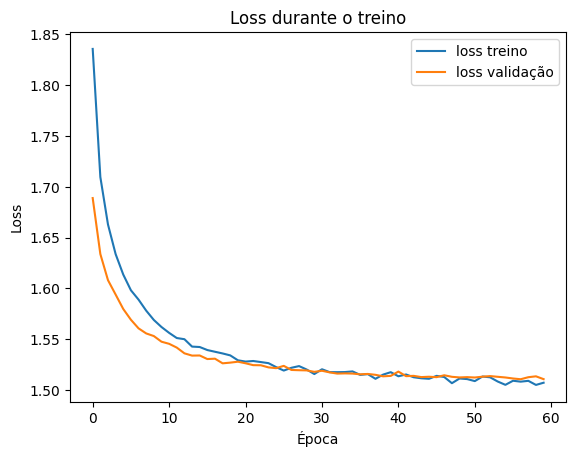

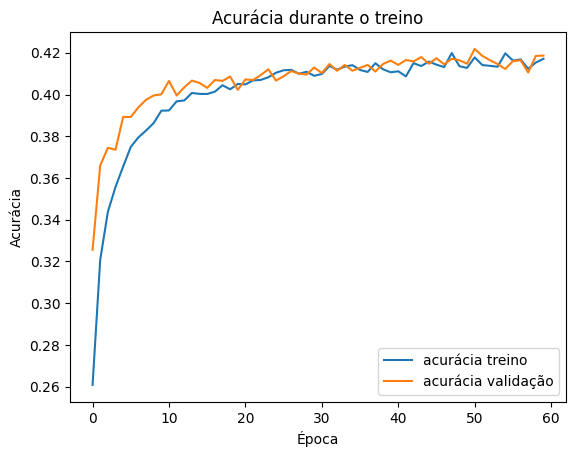

In [10]:
import matplotlib.pyplot as plt

# Suponha que você tenha treinado seu modelo assim:
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

# Para plotar loss e val_loss
plt.plot(history.history['loss'], label='loss treino')
plt.plot(history.history['val_loss'], label='loss validação')
plt.title('Loss durante o treino')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Para plotar accuracy e val_accuracy (se disponível)
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='acurácia treino')
    plt.plot(history.history['val_accuracy'], label='acurácia validação')
    plt.title('Acurácia durante o treino')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.show()


In [15]:
from tensorflow.keras.applications import ResNet50V2

IMG_SIZE = 48
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))


# Modelo base
base_model2 = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(48,48,3),
    pooling=None,
    classes=7,
    classifier_activation="softmax",
    name="densenet201",
)

base_model2.trainable = False

# Topo da rede
x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(LABEL_MAP), activation="softmax")(x)

model2 = Model(inputs=base_model2.input, outputs=predictions)

# Compilação
model2.compile(optimizer=Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model2.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 12, 12,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 12, 12,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 14, 14,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 12, 12,    │          0 │ conv2_block1_0_c

 Total params: 23,579,143 (89.95 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [16]:
history2 = model2.fit(
    X_train_resized, y_train_cat,
    validation_data=(X_test_resized, y_test_cat),
    epochs=60,
    batch_size=32
)

Epoch 1/60


2025-08-11 15:29:13.290202: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 793746432 exceeds 10% of free system memory.


898/898 ━━━━━━━━━━━━━━━━━━━━ 70s 72ms/step - accuracy: 0.2301 - loss: 2.7128 - val_accuracy: 0.3208 - val_loss: 1.8507
Epoch 2/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.2822 - loss: 2.0817 - val_accuracy: 0.3533 - val_loss: 1.7114
Epoch 3/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.3185 - loss: 1.8706 - val_accuracy: 0.3681 - val_loss: 1.6621
Epoch 4/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.3426 - loss: 1.7560 - val_accuracy: 0.3820 - val_loss: 1.6205
Epoch 5/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.3606 - loss: 1.6888 - val_accuracy: 0.3873 - val_loss: 1.5993
Epoch 6/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.3713 - loss: 1.6449 - val_accuracy: 0.3950 - val_loss: 1.5809
Epoch 7/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.3811 - loss: 1.6129 - val_accuracy: 0.3980 - val_loss: 1.5731
Epoch 8/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.3915 - loss: 1.5898 - val_accurac

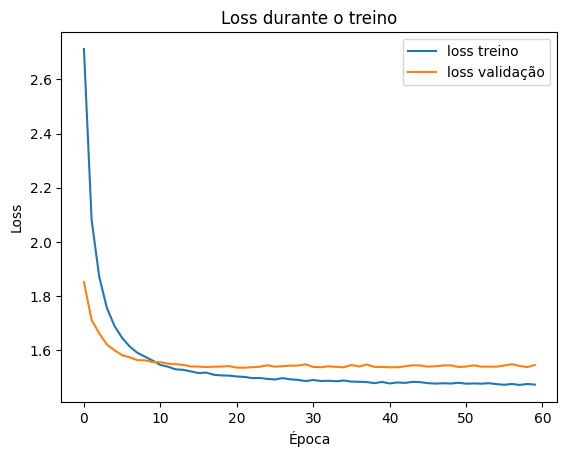

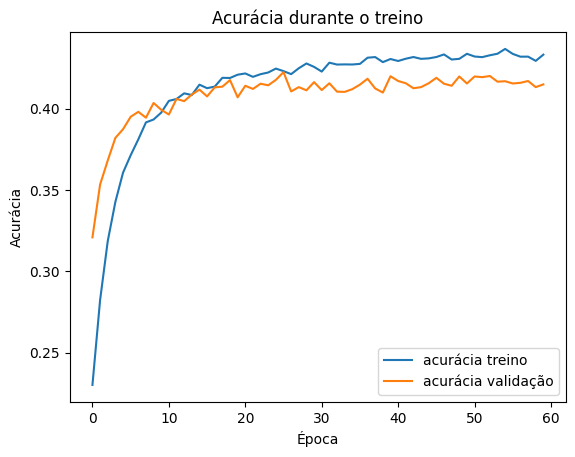

In [17]:
plt.plot(history2.history['loss'], label='loss treino')
plt.plot(history2.history['val_loss'], label='loss validação')
plt.title('Loss durante o treino')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Para plotar accuracy e val_accuracy (se disponível)
if 'accuracy' in history2.history:
    plt.plot(history2.history['accuracy'], label='acurácia treino')
    plt.plot(history2.history['val_accuracy'], label='acurácia validação')
    plt.title('Acurácia durante o treino')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.show()

In [21]:
from tensorflow.keras.applications import EfficientNetV2B1

IMG_SIZE = 48
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))


# Modelo base
base_model3 = EfficientNetV2B1(
    include_top=False,
    weights="imagenet",
    input_shape=(48,48,3),
    pooling=None,
    classes=7,
    classifier_activation="softmax"
)

base_model3.trainable = False

# Topo da rede
x = base_model3.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(LABEL_MAP), activation="softmax")(x)

model3 = Model(inputs=base_model3.input, outputs=predictions)

# Compilação
model3.compile(optimizer=Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model3.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 48, 48, 3) │          0 │ input_layer_13[0… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 48, 48, 3) │          0 │ rescaling_1[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 24, 24,    │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 24, 24,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 24, 24,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 24, 24,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 24, 24,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 24, 24,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 24, 24,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 24, 24,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 24, 24,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 24, 24,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 24, 24,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 12, 12,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 12, 12,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 12, 12,    │          0 │ block2a_expand_b

 Total params: 6,940,091 (26.47 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 6,931,124 (26.44 MB)

In [22]:
histor3 = model3.fit(
    X_train_resized, y_train_cat,
    validation_data=(X_test_resized, y_test_cat),
    epochs=60,
    batch_size=32
)

Epoch 1/60


2025-08-11 16:41:22.546942: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 793746432 exceeds 10% of free system memory.


898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 53ms/step - accuracy: 0.2221 - loss: 1.8440 - val_accuracy: 0.2471 - val_loss: 1.8141
Epoch 2/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 50ms/step - accuracy: 0.2308 - loss: 1.8350 - val_accuracy: 0.2471 - val_loss: 1.8144
Epoch 3/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.2287 - loss: 1.8350 - val_accuracy: 0.2471 - val_loss: 1.8163
Epoch 4/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.2345 - loss: 1.8302 - val_accuracy: 0.2471 - val_loss: 1.8145
Epoch 5/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.2359 - loss: 1.8301 - val_accuracy: 0.2471 - val_loss: 1.8152
Epoch 6/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.2365 - loss: 1.8291 - val_accuracy: 0.2471 - val_loss: 1.8146
Epoch 7/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.2361 - loss: 1.8285 - val_accuracy: 0.2471 - val_loss: 1.8173
Epoch 8/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.2378 - loss: 1.8284 - val_accurac

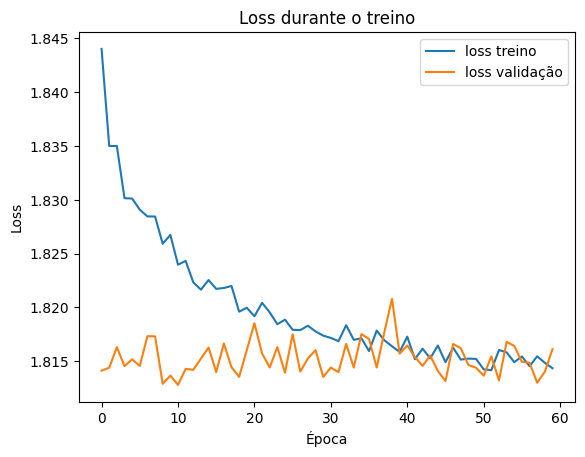

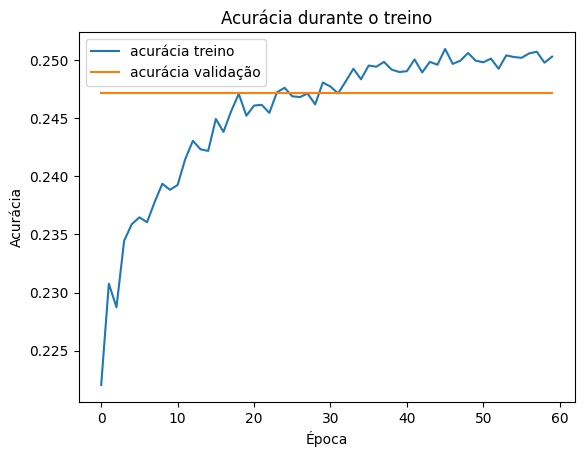

In [24]:
plt.plot(histor3.history['loss'], label='loss treino')
plt.plot(histor3.history['val_loss'], label='loss validação')
plt.title('Loss durante o treino')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Para plotar accuracy e val_accuracy (se disponível)
if 'accuracy' in histor3.history:
    plt.plot(histor3.history['accuracy'], label='acurácia treino')
    plt.plot(histor3.history['val_accuracy'], label='acurácia validação')
    plt.title('Acurácia durante o treino')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.show()